In [1]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path

# Change this to where you put your hw1 files
DATA = Path("/content/drive/MyDrive/Fed_unchanged/FedPD/Python")

In [3]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from torch import nn

torch.manual_seed(0)

In [4]:
os.chdir(DATA / 'src')
from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, CNNFEMnist
from utils import get_dataset, average_weights, exp_details
from agent import Agent

In [5]:
class arg:
  def __init__(self):
    self.epochs = 200 #changed from 1000 
    self.freq_in = 300 
    self.freq_out = 1 
    self.num_users = 30 # changed from 90
    self.partial_users = 10
    self.local_ep = 300
    self.local_bs = 2
    self.lr = 0.01
    self.mu = 1
    self.dataset = 'femnist'
    self.VR = False
    self.model = 'cnn' 
    self.optimizer = 'FedPD' 
    self.gpu = False
args = arg()

In [6]:
# This cell is to load FeMNIST data
path_project = os.path.abspath('..')
if args.gpu:
        torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

using femnist


In [7]:
import json
data_dir = '../data/femnist/'+'/train'
files = os.listdir(data_dir)
file_path = os.path.join(data_dir,files[0])
with open(file_path, 'r') as inf:
            cdata = json.load(inf)
from collections import defaultdict
data = defaultdict(lambda : None)
data.update(cdata['user_data'])

global_model = CNNFEMnist(args=args)
global_model.train()

CNNFEMnist(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=2048, out_features=62, bias=True)
)

In [8]:
agent_list = []
for i in range(args.num_users):
    agent_list.append(Agent(global_model,args,i, nn.NLLLoss().to(device)))

# copy weights
global_weights = global_model.state_dict()

In [9]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0

In [10]:
import random
random.seed(10)
global_dict = {}
for epoch in tqdm(range(args.epochs)):
  local_weights = []
  print(f'\n | Global Training Round : {epoch+1} |\n')

  m = args.num_users
  if epoch % args.freq_out ==0:
      compute_full = True
      update_model = True
  else:
      compute_full = False
      update_model = False
  global_model.train()

  if epoch == 0:
    for idx in range(args.num_users):
      global_dict[str(idx)] = global_model.state_dict()

  S = [str(i) for i in random.sample(range(args.num_users),args.partial_users)]

  for idx in S:
      w= agent_list[int(idx)].train_(global_model.state_dict(), args.freq_in, train_dataset, user_groups, update_model, compute_full)
      # print(w['layer3.0.bias'])
      local_weights.append(copy.deepcopy(w))
      global_dict[idx] = local_weights[-1]
  # for idx in range(args.num_users):
  #     print(local_weights[idx]['layer3.0.bias'])


  if S:
      w_avg = copy.deepcopy(local_weights[0])
      w_avg = {key: w_avg[key]-w_avg[key] for key in w_avg.keys()}
      for key in w_avg.keys():
          for i in range(args.num_users):
              w_avg[key].add_(global_dict[str(i)][key])
          w_avg[key].div_(args.num_users)
  # print(w_avg['layer3.0.bias'])

  # update global weights
      global_weights = w_avg

  # update global weights
      global_model.load_state_dict(global_weights)
  # print(global_model)

  # Calculate avg training accuracy over all users at every epoch
  global_model.eval()
  test_acc, test_loss = test_inference(args, global_model, test_dataset)
  train_accuracy.append(test_acc)
  train_loss.append(test_loss)

  # print global training loss after every 'i' rounds
  if (epoch+1) % print_every == 0:
      print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      print(f'Training Loss : {np.mean(np.array(train_loss))}')
      print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]),flush=True)

  0%|          | 0/200 [00:00<?, ?it/s]


 | Global Training Round : 1 |



/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/agent.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image,dtype=torch.float32), torch.tensor(label)
/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/optimizer.py:198: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.add_(-group['lr']*mu, p.data-x_0)


 
Avg Training Stats after 1 global rounds:
Training Loss : 111.50125789642334
Train Accuracy: 3.64% 



  0%|          | 1/200 [02:51<9:27:51, 171.21s/it]


 | Global Training Round : 2 |

 
Avg Training Stats after 2 global rounds:
Training Loss : 108.55015623569489
Train Accuracy: 5.31% 



  1%|          | 2/200 [05:41<9:23:51, 170.87s/it]


 | Global Training Round : 3 |

 
Avg Training Stats after 3 global rounds:
Training Loss : 107.55883232752483
Train Accuracy: 5.31% 



  2%|▏         | 3/200 [08:33<9:21:40, 171.07s/it]


 | Global Training Round : 4 |

 
Avg Training Stats after 4 global rounds:
Training Loss : 106.98336720466614
Train Accuracy: 5.31% 



  2%|▏         | 4/200 [11:21<9:15:24, 170.03s/it]


 | Global Training Round : 5 |

 
Avg Training Stats after 5 global rounds:
Training Loss : 106.55587620735169
Train Accuracy: 5.31% 



  2%|▎         | 5/200 [14:08<9:09:28, 169.07s/it]


 | Global Training Round : 6 |

 
Avg Training Stats after 6 global rounds:
Training Loss : 106.30494678020477
Train Accuracy: 5.31% 



  3%|▎         | 6/200 [16:56<9:05:22, 168.67s/it]


 | Global Training Round : 7 |

 
Avg Training Stats after 7 global rounds:
Training Loss : 106.14608342306954
Train Accuracy: 5.54% 



  4%|▎         | 7/200 [19:47<9:04:55, 169.41s/it]


 | Global Training Round : 8 |

 
Avg Training Stats after 8 global rounds:
Training Loss : 106.0320657491684
Train Accuracy: 5.26% 



  4%|▍         | 8/200 [22:36<9:01:52, 169.34s/it]


 | Global Training Round : 9 |

 
Avg Training Stats after 9 global rounds:
Training Loss : 105.9523269865248
Train Accuracy: 5.26% 



  4%|▍         | 9/200 [25:33<9:06:05, 171.55s/it]


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 105.90461931228637
Train Accuracy: 5.29% 



  5%|▌         | 10/200 [28:29<9:07:41, 172.95s/it]


 | Global Training Round : 11 |

 
Avg Training Stats after 11 global rounds:
Training Loss : 105.83305289528586
Train Accuracy: 5.31% 



  6%|▌         | 11/200 [31:26<9:08:17, 174.06s/it]


 | Global Training Round : 12 |

 
Avg Training Stats after 12 global rounds:
Training Loss : 105.7842469215393
Train Accuracy: 5.31% 



  6%|▌         | 12/200 [34:26<9:11:18, 175.95s/it]


 | Global Training Round : 13 |

 
Avg Training Stats after 13 global rounds:
Training Loss : 105.75780806174645
Train Accuracy: 5.31% 



  6%|▋         | 13/200 [37:32<9:18:22, 179.16s/it]


 | Global Training Round : 14 |

 
Avg Training Stats after 14 global rounds:
Training Loss : 105.71765090738025
Train Accuracy: 5.31% 



  7%|▋         | 14/200 [40:35<9:18:27, 180.15s/it]


 | Global Training Round : 15 |

 
Avg Training Stats after 15 global rounds:
Training Loss : 105.6760148048401
Train Accuracy: 5.31% 



  8%|▊         | 15/200 [43:34<9:14:35, 179.87s/it]


 | Global Training Round : 16 |

 
Avg Training Stats after 16 global rounds:
Training Loss : 105.62996962666512
Train Accuracy: 5.31% 



  8%|▊         | 16/200 [46:24<9:02:39, 176.95s/it]


 | Global Training Round : 17 |

 
Avg Training Stats after 17 global rounds:
Training Loss : 105.58903274816625
Train Accuracy: 5.51% 



  8%|▊         | 17/200 [49:17<8:56:03, 175.76s/it]


 | Global Training Round : 18 |

 
Avg Training Stats after 18 global rounds:
Training Loss : 105.55046314663358
Train Accuracy: 5.31% 



  9%|▉         | 18/200 [52:10<8:50:42, 174.96s/it]


 | Global Training Round : 19 |

 
Avg Training Stats after 19 global rounds:
Training Loss : 105.5062127615276
Train Accuracy: 5.31% 



 10%|▉         | 19/200 [55:04<8:46:48, 174.63s/it]


 | Global Training Round : 20 |

 
Avg Training Stats after 20 global rounds:
Training Loss : 105.4616754412651
Train Accuracy: 9.96% 



 10%|█         | 20/200 [57:59<8:43:49, 174.61s/it]


 | Global Training Round : 21 |

 
Avg Training Stats after 21 global rounds:
Training Loss : 105.44352856136504
Train Accuracy: 5.31% 



 10%|█         | 21/200 [1:00:54<8:41:14, 174.72s/it]


 | Global Training Round : 22 |

 
Avg Training Stats after 22 global rounds:
Training Loss : 105.41621168093248
Train Accuracy: 5.31% 



 11%|█         | 22/200 [1:03:47<8:37:02, 174.28s/it]


 | Global Training Round : 23 |

 
Avg Training Stats after 23 global rounds:
Training Loss : 105.38987335951433
Train Accuracy: 5.31% 



 12%|█▏        | 23/200 [1:06:40<8:33:11, 173.96s/it]


 | Global Training Round : 24 |

 
Avg Training Stats after 24 global rounds:
Training Loss : 105.35641444722812
Train Accuracy: 6.63% 



 12%|█▏        | 24/200 [1:09:29<8:26:08, 172.55s/it]


 | Global Training Round : 25 |

 
Avg Training Stats after 25 global rounds:
Training Loss : 105.32603110313416
Train Accuracy: 9.15% 



 12%|█▎        | 25/200 [1:12:20<8:21:17, 171.87s/it]


 | Global Training Round : 26 |

 
Avg Training Stats after 26 global rounds:
Training Loss : 105.29915746358725
Train Accuracy: 13.43% 



 13%|█▎        | 26/200 [1:15:08<8:15:08, 170.74s/it]


 | Global Training Round : 27 |

 
Avg Training Stats after 27 global rounds:
Training Loss : 105.2785181734297
Train Accuracy: 10.15% 



 14%|█▎        | 27/200 [1:18:00<8:13:09, 171.04s/it]


 | Global Training Round : 28 |

 
Avg Training Stats after 28 global rounds:
Training Loss : 105.25719838482993
Train Accuracy: 5.31% 



 14%|█▍        | 28/200 [1:20:50<8:10:14, 171.02s/it]


 | Global Training Round : 29 |

 
Avg Training Stats after 29 global rounds:
Training Loss : 105.23867507638603
Train Accuracy: 10.15% 



 14%|█▍        | 29/200 [1:23:36<8:02:51, 169.43s/it]


 | Global Training Round : 30 |

 
Avg Training Stats after 30 global rounds:
Training Loss : 105.21124473412831
Train Accuracy: 10.10% 



 15%|█▌        | 30/200 [1:26:11<7:47:39, 165.05s/it]


 | Global Training Round : 31 |

 
Avg Training Stats after 31 global rounds:
Training Loss : 105.1796694186426
Train Accuracy: 5.31% 



 16%|█▌        | 31/200 [1:28:43<7:34:10, 161.25s/it]


 | Global Training Round : 32 |

 
Avg Training Stats after 32 global rounds:
Training Loss : 105.15380730479956
Train Accuracy: 5.31% 



 16%|█▌        | 32/200 [1:31:17<7:25:12, 159.01s/it]


 | Global Training Round : 33 |

 
Avg Training Stats after 33 global rounds:
Training Loss : 105.13971000729185
Train Accuracy: 5.31% 



 16%|█▋        | 33/200 [1:33:56<7:22:46, 159.08s/it]


 | Global Training Round : 34 |

 
Avg Training Stats after 34 global rounds:
Training Loss : 105.12390890542198
Train Accuracy: 5.31% 



 17%|█▋        | 34/200 [1:36:35<7:19:33, 158.87s/it]


 | Global Training Round : 35 |

 
Avg Training Stats after 35 global rounds:
Training Loss : 105.09829969406128
Train Accuracy: 10.27% 



 18%|█▊        | 35/200 [1:39:12<7:15:21, 158.31s/it]


 | Global Training Round : 36 |

 
Avg Training Stats after 36 global rounds:
Training Loss : 105.06798362731934
Train Accuracy: 10.24% 



 18%|█▊        | 36/200 [1:41:46<7:09:02, 156.97s/it]


 | Global Training Round : 37 |

 
Avg Training Stats after 37 global rounds:
Training Loss : 105.03584035667214
Train Accuracy: 10.18% 



 18%|█▊        | 37/200 [1:44:37<7:18:17, 161.33s/it]


 | Global Training Round : 38 |

 
Avg Training Stats after 38 global rounds:
Training Loss : 104.99951335003502
Train Accuracy: 9.17% 



 19%|█▉        | 38/200 [1:47:25<7:20:48, 163.26s/it]


 | Global Training Round : 39 |

 
Avg Training Stats after 39 global rounds:
Training Loss : 104.96911767812875
Train Accuracy: 14.10% 



 20%|█▉        | 39/200 [1:50:17<7:25:22, 165.98s/it]


 | Global Training Round : 40 |

 
Avg Training Stats after 40 global rounds:
Training Loss : 104.93731507658958
Train Accuracy: 9.20% 



 20%|██        | 40/200 [1:53:12<7:29:35, 168.59s/it]


 | Global Training Round : 41 |

 
Avg Training Stats after 41 global rounds:
Training Loss : 104.9067121889533
Train Accuracy: 12.11% 



 20%|██        | 41/200 [1:56:07<7:31:54, 170.53s/it]


 | Global Training Round : 42 |

 
Avg Training Stats after 42 global rounds:
Training Loss : 104.87457252684094
Train Accuracy: 9.93% 



 21%|██        | 42/200 [1:59:02<7:32:29, 171.83s/it]


 | Global Training Round : 43 |

 
Avg Training Stats after 43 global rounds:
Training Loss : 104.83592807969382
Train Accuracy: 9.93% 



 22%|██▏       | 43/200 [2:01:57<7:31:59, 172.74s/it]


 | Global Training Round : 44 |

 
Avg Training Stats after 44 global rounds:
Training Loss : 104.79619390314275
Train Accuracy: 10.15% 



 22%|██▏       | 44/200 [2:04:51<7:30:32, 173.29s/it]


 | Global Training Round : 45 |

 
Avg Training Stats after 45 global rounds:
Training Loss : 104.75455706914266
Train Accuracy: 11.69% 



 22%|██▎       | 45/200 [2:07:46<7:28:44, 173.71s/it]


 | Global Training Round : 46 |

 
Avg Training Stats after 46 global rounds:
Training Loss : 104.70792158790256
Train Accuracy: 10.49% 



 23%|██▎       | 46/200 [2:10:41<7:26:48, 174.08s/it]


 | Global Training Round : 47 |

 
Avg Training Stats after 47 global rounds:
Training Loss : 104.6595667270904
Train Accuracy: 9.12% 



 24%|██▎       | 47/200 [2:13:36<7:24:41, 174.39s/it]


 | Global Training Round : 48 |

 
Avg Training Stats after 48 global rounds:
Training Loss : 104.603294317921
Train Accuracy: 10.94% 



 24%|██▍       | 48/200 [2:16:31<7:22:12, 174.56s/it]


 | Global Training Round : 49 |

 
Avg Training Stats after 49 global rounds:
Training Loss : 104.5445756377006
Train Accuracy: 10.80% 



 24%|██▍       | 49/200 [2:19:26<7:19:31, 174.65s/it]


 | Global Training Round : 50 |

 
Avg Training Stats after 50 global rounds:
Training Loss : 104.48371212482452
Train Accuracy: 11.69% 



 25%|██▌       | 50/200 [2:22:21<7:17:07, 174.85s/it]


 | Global Training Round : 51 |

 
Avg Training Stats after 51 global rounds:
Training Loss : 104.41675730312572
Train Accuracy: 16.00% 



 26%|██▌       | 51/200 [2:25:15<7:13:47, 174.68s/it]


 | Global Training Round : 52 |

 
Avg Training Stats after 52 global rounds:
Training Loss : 104.34182094152158
Train Accuracy: 16.59% 



 26%|██▌       | 52/200 [2:28:10<7:10:36, 174.57s/it]


 | Global Training Round : 53 |

 
Avg Training Stats after 53 global rounds:
Training Loss : 104.26308945439897
Train Accuracy: 15.41% 



 26%|██▋       | 53/200 [2:31:02<7:05:41, 173.75s/it]


 | Global Training Round : 54 |

 
Avg Training Stats after 54 global rounds:
Training Loss : 104.17671604068191
Train Accuracy: 15.50% 



 27%|██▋       | 54/200 [2:33:55<7:02:39, 173.70s/it]


 | Global Training Round : 55 |

 
Avg Training Stats after 55 global rounds:
Training Loss : 104.08079077547247
Train Accuracy: 12.28% 



 28%|██▊       | 55/200 [2:36:44<6:55:53, 172.09s/it]


 | Global Training Round : 56 |

 
Avg Training Stats after 56 global rounds:
Training Loss : 103.98015963179725
Train Accuracy: 15.50% 



 28%|██▊       | 56/200 [2:39:26<6:46:06, 169.21s/it]


 | Global Training Round : 57 |

 
Avg Training Stats after 57 global rounds:
Training Loss : 103.86643468706231
Train Accuracy: 15.89% 



 28%|██▊       | 57/200 [2:42:04<6:34:53, 165.69s/it]


 | Global Training Round : 58 |

 
Avg Training Stats after 58 global rounds:
Training Loss : 103.7378191824617
Train Accuracy: 16.73% 



 29%|██▉       | 58/200 [2:44:43<6:27:37, 163.78s/it]


 | Global Training Round : 59 |

 
Avg Training Stats after 59 global rounds:
Training Loss : 103.59375846183906
Train Accuracy: 17.03% 



 30%|██▉       | 59/200 [2:47:20<6:19:53, 161.66s/it]


 | Global Training Round : 60 |

 
Avg Training Stats after 60 global rounds:
Training Loss : 103.43124070167542
Train Accuracy: 17.93% 



 30%|███       | 60/200 [2:49:54<6:12:23, 159.60s/it]


 | Global Training Round : 61 |

 
Avg Training Stats after 61 global rounds:
Training Loss : 103.25171512463054
Train Accuracy: 18.27% 



 30%|███       | 61/200 [2:52:37<6:11:54, 160.54s/it]


 | Global Training Round : 62 |

 
Avg Training Stats after 62 global rounds:
Training Loss : 103.05211875900146
Train Accuracy: 20.28% 



 31%|███       | 62/200 [2:55:12<6:05:16, 158.81s/it]


 | Global Training Round : 63 |

 
Avg Training Stats after 63 global rounds:
Training Loss : 102.8418165994069
Train Accuracy: 22.99% 



 32%|███▏      | 63/200 [2:57:50<6:02:08, 158.60s/it]


 | Global Training Round : 64 |

 
Avg Training Stats after 64 global rounds:
Training Loss : 102.61712151765823
Train Accuracy: 22.74% 



 32%|███▏      | 64/200 [3:00:28<5:59:15, 158.50s/it]


 | Global Training Round : 65 |

 
Avg Training Stats after 65 global rounds:
Training Loss : 102.37821500851558
Train Accuracy: 24.64% 



 32%|███▎      | 65/200 [3:03:08<5:57:16, 158.79s/it]


 | Global Training Round : 66 |

 
Avg Training Stats after 66 global rounds:
Training Loss : 102.13555442925656
Train Accuracy: 26.99% 



 33%|███▎      | 66/200 [3:05:46<5:54:01, 158.52s/it]


 | Global Training Round : 67 |

 
Avg Training Stats after 67 global rounds:
Training Loss : 101.88722112997254
Train Accuracy: 26.46% 



 34%|███▎      | 67/200 [3:08:29<5:54:29, 159.92s/it]


 | Global Training Round : 68 |

 
Avg Training Stats after 68 global rounds:
Training Loss : 101.62903027324116
Train Accuracy: 25.99% 



 34%|███▍      | 68/200 [3:11:15<5:55:52, 161.76s/it]


 | Global Training Round : 69 |

 
Avg Training Stats after 69 global rounds:
Training Loss : 101.35290109247401
Train Accuracy: 27.61% 



 34%|███▍      | 69/200 [3:14:02<5:57:00, 163.52s/it]


 | Global Training Round : 70 |

 
Avg Training Stats after 70 global rounds:
Training Loss : 101.05860450948988
Train Accuracy: 28.78% 



 35%|███▌      | 70/200 [3:16:37<5:48:24, 160.81s/it]


 | Global Training Round : 71 |

 
Avg Training Stats after 71 global rounds:
Training Loss : 100.75522825079905
Train Accuracy: 30.80% 



 36%|███▌      | 71/200 [3:19:09<5:40:22, 158.32s/it]


 | Global Training Round : 72 |

 
Avg Training Stats after 72 global rounds:
Training Loss : 100.44060346153047
Train Accuracy: 33.68% 



 36%|███▌      | 72/200 [3:21:41<5:33:37, 156.39s/it]


 | Global Training Round : 73 |

 
Avg Training Stats after 73 global rounds:
Training Loss : 100.12220635152843
Train Accuracy: 33.68% 



 36%|███▋      | 73/200 [3:24:16<5:29:53, 155.86s/it]


 | Global Training Round : 74 |

 
Avg Training Stats after 74 global rounds:
Training Loss : 99.80162475560162
Train Accuracy: 35.22% 



 37%|███▋      | 74/200 [3:26:48<5:24:46, 154.66s/it]


 | Global Training Round : 75 |

 
Avg Training Stats after 75 global rounds:
Training Loss : 99.47515698750814
Train Accuracy: 36.14% 



 38%|███▊      | 75/200 [3:29:19<5:20:20, 153.76s/it]


 | Global Training Round : 76 |

 
Avg Training Stats after 76 global rounds:
Training Loss : 99.13981271417518
Train Accuracy: 35.78% 



 38%|███▊      | 76/200 [3:32:04<5:24:19, 156.93s/it]


 | Global Training Round : 77 |

 
Avg Training Stats after 77 global rounds:
Training Loss : 98.80136891464134
Train Accuracy: 36.98% 



 38%|███▊      | 77/200 [3:34:49<5:26:48, 159.42s/it]


 | Global Training Round : 78 |

 
Avg Training Stats after 78 global rounds:
Training Loss : 98.45223376995477
Train Accuracy: 37.68% 



 39%|███▉      | 78/200 [3:37:32<5:26:23, 160.52s/it]


 | Global Training Round : 79 |

 
Avg Training Stats after 79 global rounds:
Training Loss : 98.09851814825323
Train Accuracy: 39.05% 



 40%|███▉      | 79/200 [3:40:09<5:21:28, 159.41s/it]


 | Global Training Round : 80 |

 
Avg Training Stats after 80 global rounds:
Training Loss : 97.74168115854263
Train Accuracy: 39.83% 



 40%|████      | 80/200 [3:42:51<5:20:18, 160.15s/it]


 | Global Training Round : 81 |

 
Avg Training Stats after 81 global rounds:
Training Loss : 97.38951923817764
Train Accuracy: 39.61% 



 40%|████      | 81/200 [3:45:38<5:21:59, 162.35s/it]


 | Global Training Round : 82 |

 
Avg Training Stats after 82 global rounds:
Training Loss : 97.0287323143424
Train Accuracy: 42.21% 



 41%|████      | 82/200 [3:48:14<5:15:27, 160.41s/it]


 | Global Training Round : 83 |

 
Avg Training Stats after 83 global rounds:
Training Loss : 96.66721506578376
Train Accuracy: 42.13% 



 42%|████▏     | 83/200 [3:50:51<5:10:52, 159.43s/it]


 | Global Training Round : 84 |

 
Avg Training Stats after 84 global rounds:
Training Loss : 96.29681759505044
Train Accuracy: 42.43% 



 42%|████▏     | 84/200 [3:53:40<5:13:23, 162.10s/it]


 | Global Training Round : 85 |

 
Avg Training Stats after 85 global rounds:
Training Loss : 95.93036806162665
Train Accuracy: 41.59% 



 42%|████▎     | 85/200 [3:56:20<5:09:26, 161.45s/it]


 | Global Training Round : 86 |

 
Avg Training Stats after 86 global rounds:
Training Loss : 95.56289819506712
Train Accuracy: 41.51% 



 43%|████▎     | 86/200 [3:59:03<5:07:49, 162.02s/it]


 | Global Training Round : 87 |

 
Avg Training Stats after 87 global rounds:
Training Loss : 95.18776726311651
Train Accuracy: 43.83% 



 44%|████▎     | 87/200 [4:01:48<5:07:08, 163.09s/it]


 | Global Training Round : 88 |

 
Avg Training Stats after 88 global rounds:
Training Loss : 94.81416259028695
Train Accuracy: 43.72% 



 44%|████▍     | 88/200 [4:04:20<4:58:07, 159.71s/it]


 | Global Training Round : 89 |

 
Avg Training Stats after 89 global rounds:
Training Loss : 94.4385033644987
Train Accuracy: 46.27% 



 44%|████▍     | 89/200 [4:07:00<4:55:16, 159.61s/it]


 | Global Training Round : 90 |

 
Avg Training Stats after 90 global rounds:
Training Loss : 94.05936252143648
Train Accuracy: 47.55% 



 45%|████▌     | 90/200 [4:09:42<4:53:52, 160.29s/it]


 | Global Training Round : 91 |

 
Avg Training Stats after 91 global rounds:
Training Loss : 93.68596734712412
Train Accuracy: 46.07% 



 46%|████▌     | 91/200 [4:12:26<4:53:36, 161.62s/it]


 | Global Training Round : 92 |

 
Avg Training Stats after 92 global rounds:
Training Loss : 93.30173964085786
Train Accuracy: 47.86% 



 46%|████▌     | 92/200 [4:15:10<4:52:11, 162.32s/it]


 | Global Training Round : 93 |

 
Avg Training Stats after 93 global rounds:
Training Loss : 92.91923224285085
Train Accuracy: 49.03% 



 46%|████▋     | 93/200 [4:17:49<4:47:45, 161.36s/it]


 | Global Training Round : 94 |

 
Avg Training Stats after 94 global rounds:
Training Loss : 92.53428541472617
Train Accuracy: 49.82% 



 47%|████▋     | 94/200 [4:20:40<4:49:54, 164.10s/it]


 | Global Training Round : 95 |

 
Avg Training Stats after 95 global rounds:
Training Loss : 92.15000124730562
Train Accuracy: 49.57% 



 48%|████▊     | 95/200 [4:23:39<4:55:01, 168.59s/it]


 | Global Training Round : 96 |

 
Avg Training Stats after 96 global rounds:
Training Loss : 91.76699539646506
Train Accuracy: 51.13% 



 48%|████▊     | 96/200 [4:26:39<4:58:02, 171.95s/it]


 | Global Training Round : 97 |

 
Avg Training Stats after 97 global rounds:
Training Loss : 91.38258302334657
Train Accuracy: 52.00% 



 48%|████▊     | 97/200 [4:29:37<4:58:33, 173.92s/it]


 | Global Training Round : 98 |

 
Avg Training Stats after 98 global rounds:
Training Loss : 90.9964083420987
Train Accuracy: 52.42% 



 49%|████▉     | 98/200 [4:32:35<4:57:40, 175.11s/it]


 | Global Training Round : 99 |

 
Avg Training Stats after 99 global rounds:
Training Loss : 90.61140636000971
Train Accuracy: 52.73% 



 50%|████▉     | 99/200 [4:35:23<4:51:07, 172.95s/it]


 | Global Training Round : 100 |

 
Avg Training Stats after 100 global rounds:
Training Loss : 90.22374405145645
Train Accuracy: 53.65% 



 50%|█████     | 100/200 [4:38:09<4:44:49, 170.89s/it]


 | Global Training Round : 101 |

 
Avg Training Stats after 101 global rounds:
Training Loss : 89.83783186426257
Train Accuracy: 53.76% 



 50%|█████     | 101/200 [4:40:53<4:38:21, 168.70s/it]


 | Global Training Round : 102 |

 
Avg Training Stats after 102 global rounds:
Training Loss : 89.45148583954456
Train Accuracy: 54.04% 



 51%|█████     | 102/200 [4:43:35<4:32:12, 166.66s/it]


 | Global Training Round : 103 |

 
Avg Training Stats after 103 global rounds:
Training Loss : 89.06594809629385
Train Accuracy: 55.27% 



 52%|█████▏    | 103/200 [4:46:15<4:26:15, 164.69s/it]


 | Global Training Round : 104 |

 
Avg Training Stats after 104 global rounds:
Training Loss : 88.67634476148166
Train Accuracy: 55.89% 



 52%|█████▏    | 104/200 [4:48:51<4:19:37, 162.27s/it]


 | Global Training Round : 105 |

 
Avg Training Stats after 105 global rounds:
Training Loss : 88.28899270920526
Train Accuracy: 55.94% 



 52%|█████▎    | 105/200 [4:51:36<4:18:03, 162.99s/it]


 | Global Training Round : 106 |

 
Avg Training Stats after 106 global rounds:
Training Loss : 87.90301743205988
Train Accuracy: 56.11% 



 53%|█████▎    | 106/200 [4:54:28<4:19:24, 165.58s/it]


 | Global Training Round : 107 |

 
Avg Training Stats after 107 global rounds:
Training Loss : 87.51720203751715
Train Accuracy: 57.23% 



 54%|█████▎    | 107/200 [4:57:23<4:21:13, 168.53s/it]


 | Global Training Round : 108 |

 
Avg Training Stats after 108 global rounds:
Training Loss : 87.13427119564128
Train Accuracy: 58.35% 



 54%|█████▍    | 108/200 [5:00:30<4:26:49, 174.02s/it]


 | Global Training Round : 109 |

 
Avg Training Stats after 109 global rounds:
Training Loss : 86.75216998747729
Train Accuracy: 58.13% 



 55%|█████▍    | 109/200 [5:03:23<4:23:18, 173.61s/it]


 | Global Training Round : 110 |

 
Avg Training Stats after 110 global rounds:
Training Loss : 86.37185437570919
Train Accuracy: 58.55% 



 55%|█████▌    | 110/200 [5:06:15<4:19:56, 173.29s/it]


 | Global Training Round : 111 |

 
Avg Training Stats after 111 global rounds:
Training Loss : 85.99628764981622
Train Accuracy: 58.80% 



 56%|█████▌    | 111/200 [5:09:08<4:17:03, 173.30s/it]


 | Global Training Round : 112 |

 
Avg Training Stats after 112 global rounds:
Training Loss : 85.62066977151802
Train Accuracy: 60.17% 



 56%|█████▌    | 112/200 [5:12:02<4:14:25, 173.47s/it]


 | Global Training Round : 113 |

 
Avg Training Stats after 113 global rounds:
Training Loss : 85.2479607985083
Train Accuracy: 60.17% 



 56%|█████▋    | 113/200 [5:14:50<4:08:54, 171.66s/it]


 | Global Training Round : 114 |

 
Avg Training Stats after 114 global rounds:
Training Loss : 84.87800165017445
Train Accuracy: 60.22% 



 57%|█████▋    | 114/200 [5:17:35<4:03:23, 169.81s/it]


 | Global Training Round : 115 |

 
Avg Training Stats after 115 global rounds:
Training Loss : 84.51066336320794
Train Accuracy: 60.03% 



 57%|█████▊    | 115/200 [5:20:29<4:02:07, 170.92s/it]


 | Global Training Round : 116 |

 
Avg Training Stats after 116 global rounds:
Training Loss : 84.14554109038978
Train Accuracy: 60.42% 



 58%|█████▊    | 116/200 [5:23:23<4:00:45, 171.97s/it]


 | Global Training Round : 117 |

 
Avg Training Stats after 117 global rounds:
Training Loss : 83.78204006618924
Train Accuracy: 61.71% 



 58%|█████▊    | 117/200 [5:26:14<3:57:17, 171.53s/it]


 | Global Training Round : 118 |

 
Avg Training Stats after 118 global rounds:
Training Loss : 83.41760272595842
Train Accuracy: 62.69% 



 59%|█████▉    | 118/200 [5:29:00<3:52:13, 169.92s/it]


 | Global Training Round : 119 |

 
Avg Training Stats after 119 global rounds:
Training Loss : 83.05355136134044
Train Accuracy: 62.49% 



 60%|█████▉    | 119/200 [5:31:53<3:50:50, 170.99s/it]


 | Global Training Round : 120 |

 
Avg Training Stats after 120 global rounds:
Training Loss : 82.69006049235662
Train Accuracy: 62.91% 



 60%|██████    | 120/200 [5:34:35<3:44:29, 168.37s/it]


 | Global Training Round : 121 |

 
Avg Training Stats after 121 global rounds:
Training Loss : 82.3308689978497
Train Accuracy: 63.36% 



 60%|██████    | 121/200 [5:37:18<3:39:27, 166.67s/it]


 | Global Training Round : 122 |

 
Avg Training Stats after 122 global rounds:
Training Loss : 81.97553637868069
Train Accuracy: 64.36% 



 61%|██████    | 122/200 [5:40:01<3:35:13, 165.56s/it]


 | Global Training Round : 123 |

 
Avg Training Stats after 123 global rounds:
Training Loss : 81.62268748903662
Train Accuracy: 64.56% 



 62%|██████▏   | 123/200 [5:42:43<3:31:05, 164.49s/it]


 | Global Training Round : 124 |

 
Avg Training Stats after 124 global rounds:
Training Loss : 81.2715936072411
Train Accuracy: 64.73% 



 62%|██████▏   | 124/200 [5:45:30<3:29:13, 165.18s/it]


 | Global Training Round : 125 |

 
Avg Training Stats after 125 global rounds:
Training Loss : 80.9247351064682
Train Accuracy: 65.01% 



 62%|██████▎   | 125/200 [5:48:12<3:25:18, 164.25s/it]


 | Global Training Round : 126 |

 
Avg Training Stats after 126 global rounds:
Training Loss : 80.5788219637341
Train Accuracy: 65.37% 



 63%|██████▎   | 126/200 [5:50:53<3:21:29, 163.38s/it]


 | Global Training Round : 127 |

 
Avg Training Stats after 127 global rounds:
Training Loss : 80.23549985322427
Train Accuracy: 65.45% 



 64%|██████▎   | 127/200 [5:53:35<3:17:59, 162.74s/it]


 | Global Training Round : 128 |

 
Avg Training Stats after 128 global rounds:
Training Loss : 79.89483501482755
Train Accuracy: 66.04% 



 64%|██████▍   | 128/200 [5:56:19<3:15:51, 163.21s/it]


 | Global Training Round : 129 |

 
Avg Training Stats after 129 global rounds:
Training Loss : 79.55711692109588
Train Accuracy: 67.22% 



 64%|██████▍   | 129/200 [5:59:09<3:15:38, 165.33s/it]


 | Global Training Round : 130 |

 
Avg Training Stats after 130 global rounds:
Training Loss : 79.22275167749478
Train Accuracy: 66.97% 



 65%|██████▌   | 130/200 [6:02:03<3:15:48, 167.84s/it]


 | Global Training Round : 131 |

 
Avg Training Stats after 131 global rounds:
Training Loss : 78.88828128758277
Train Accuracy: 67.44% 



 66%|██████▌   | 131/200 [6:05:01<3:16:27, 170.84s/it]


 | Global Training Round : 132 |

 
Avg Training Stats after 132 global rounds:
Training Loss : 78.55646656227835
Train Accuracy: 67.92% 



 66%|██████▌   | 132/200 [6:07:53<3:14:09, 171.32s/it]


 | Global Training Round : 133 |

 
Avg Training Stats after 133 global rounds:
Training Loss : 78.22471581724353
Train Accuracy: 67.92% 



 66%|██████▋   | 133/200 [6:10:35<3:08:12, 168.55s/it]


 | Global Training Round : 134 |

 
Avg Training Stats after 134 global rounds:
Training Loss : 77.89395178698781
Train Accuracy: 68.42% 



 67%|██████▋   | 134/200 [6:13:17<3:03:17, 166.62s/it]


 | Global Training Round : 135 |

 
Avg Training Stats after 135 global rounds:
Training Loss : 77.56482296828871
Train Accuracy: 69.03% 



 68%|██████▊   | 135/200 [6:15:59<2:58:46, 165.02s/it]


 | Global Training Round : 136 |

 
Avg Training Stats after 136 global rounds:
Training Loss : 77.23809269990991
Train Accuracy: 69.20% 



 68%|██████▊   | 136/200 [6:18:36<2:53:27, 162.61s/it]


 | Global Training Round : 137 |

 
Avg Training Stats after 137 global rounds:
Training Loss : 76.91491108088597
Train Accuracy: 69.85% 



 68%|██████▊   | 137/200 [6:21:17<2:50:21, 162.24s/it]


 | Global Training Round : 138 |

 
Avg Training Stats after 138 global rounds:
Training Loss : 76.59493702736454
Train Accuracy: 69.48% 



 69%|██████▉   | 138/200 [6:23:52<2:45:22, 160.04s/it]


 | Global Training Round : 139 |

 
Avg Training Stats after 139 global rounds:
Training Loss : 76.27794922770356
Train Accuracy: 69.90% 



 70%|██████▉   | 139/200 [6:26:33<2:43:08, 160.47s/it]


 | Global Training Round : 140 |

 
Avg Training Stats after 140 global rounds:
Training Loss : 75.96379542308195
Train Accuracy: 69.87% 



 70%|███████   | 140/200 [6:29:11<2:39:31, 159.53s/it]


 | Global Training Round : 141 |

 
Avg Training Stats after 141 global rounds:
Training Loss : 75.6513566484688
Train Accuracy: 70.38% 



 70%|███████   | 141/200 [6:31:44<2:34:52, 157.50s/it]


 | Global Training Round : 142 |

 
Avg Training Stats after 142 global rounds:
Training Loss : 75.34079052109114
Train Accuracy: 70.66% 



 71%|███████   | 142/200 [6:34:16<2:30:46, 155.97s/it]


 | Global Training Round : 143 |

 
Avg Training Stats after 143 global rounds:
Training Loss : 75.03294002134483
Train Accuracy: 70.66% 



 72%|███████▏  | 143/200 [6:36:48<2:26:58, 154.71s/it]


 | Global Training Round : 144 |

 
Avg Training Stats after 144 global rounds:
Training Loss : 74.72823320039444
Train Accuracy: 71.44% 



 72%|███████▏  | 144/200 [6:39:35<2:27:54, 158.47s/it]


 | Global Training Round : 145 |

 
Avg Training Stats after 145 global rounds:
Training Loss : 74.42607107368009
Train Accuracy: 71.50% 



 72%|███████▎  | 145/200 [6:42:25<2:28:24, 161.90s/it]


 | Global Training Round : 146 |

 
Avg Training Stats after 146 global rounds:
Training Loss : 74.1240292828377
Train Accuracy: 71.75% 



 73%|███████▎  | 146/200 [6:45:05<2:25:13, 161.37s/it]


 | Global Training Round : 147 |

 
Avg Training Stats after 147 global rounds:
Training Loss : 73.82343937953313
Train Accuracy: 71.66% 



 74%|███████▎  | 147/200 [6:47:49<2:23:08, 162.05s/it]


 | Global Training Round : 148 |

 
Avg Training Stats after 148 global rounds:
Training Loss : 73.5252262861342
Train Accuracy: 71.66% 



 74%|███████▍  | 148/200 [6:50:27<2:19:23, 160.84s/it]


 | Global Training Round : 149 |

 
Avg Training Stats after 149 global rounds:
Training Loss : 73.22922227486669
Train Accuracy: 72.00% 



 74%|███████▍  | 149/200 [6:53:02<2:15:26, 159.33s/it]


 | Global Training Round : 150 |

 
Avg Training Stats after 150 global rounds:
Training Loss : 72.93443659623463
Train Accuracy: 72.17% 



 75%|███████▌  | 150/200 [6:55:42<2:12:50, 159.41s/it]


 | Global Training Round : 151 |

 
Avg Training Stats after 151 global rounds:
Training Loss : 72.64204545526314
Train Accuracy: 72.62% 



 76%|███████▌  | 151/200 [6:58:29<2:11:56, 161.57s/it]


 | Global Training Round : 152 |

 
Avg Training Stats after 152 global rounds:
Training Loss : 72.35222927324082
Train Accuracy: 73.01% 



 76%|███████▌  | 152/200 [7:01:28<2:13:28, 166.84s/it]


 | Global Training Round : 153 |

 
Avg Training Stats after 153 global rounds:
Training Loss : 72.06251973264358
Train Accuracy: 73.87% 



 76%|███████▋  | 153/200 [7:04:29<2:13:57, 171.01s/it]


 | Global Training Round : 154 |

 
Avg Training Stats after 154 global rounds:
Training Loss : 71.77617918245204
Train Accuracy: 73.73% 



 77%|███████▋  | 154/200 [7:07:25<2:12:15, 172.51s/it]


 | Global Training Round : 155 |

 
Avg Training Stats after 155 global rounds:
Training Loss : 71.4918400103046
Train Accuracy: 73.76% 



 78%|███████▊  | 155/200 [7:10:22<2:10:23, 173.86s/it]


 | Global Training Round : 156 |

 
Avg Training Stats after 156 global rounds:
Training Loss : 71.20975549098773
Train Accuracy: 74.18% 



 78%|███████▊  | 156/200 [7:13:21<2:08:48, 175.66s/it]


 | Global Training Round : 157 |

 
Avg Training Stats after 157 global rounds:
Training Loss : 70.92989348454081
Train Accuracy: 74.10% 



 78%|███████▊  | 157/200 [7:16:20<2:06:31, 176.55s/it]


 | Global Training Round : 158 |

 
Avg Training Stats after 158 global rounds:
Training Loss : 70.65230400162407
Train Accuracy: 73.87% 



 79%|███████▉  | 158/200 [7:19:17<2:03:40, 176.68s/it]


 | Global Training Round : 159 |

 
Avg Training Stats after 159 global rounds:
Training Loss : 70.37844345067282
Train Accuracy: 73.73% 



 80%|███████▉  | 159/200 [7:22:14<2:00:47, 176.76s/it]


 | Global Training Round : 160 |

 
Avg Training Stats after 160 global rounds:
Training Loss : 70.10537106618285
Train Accuracy: 74.18% 



 80%|████████  | 160/200 [7:25:10<1:57:43, 176.60s/it]


 | Global Training Round : 161 |

 
Avg Training Stats after 161 global rounds:
Training Loss : 69.83316761255264
Train Accuracy: 74.66% 



 80%|████████  | 161/200 [7:27:57<1:52:56, 173.75s/it]


 | Global Training Round : 162 |

 
Avg Training Stats after 162 global rounds:
Training Loss : 69.5623576913351
Train Accuracy: 74.80% 



 81%|████████  | 162/200 [7:30:38<1:47:34, 169.84s/it]


 | Global Training Round : 163 |

 
Avg Training Stats after 163 global rounds:
Training Loss : 69.29359010684709
Train Accuracy: 75.16% 



 82%|████████▏ | 163/200 [7:33:15<1:42:22, 166.01s/it]


 | Global Training Round : 164 |

 
Avg Training Stats after 164 global rounds:
Training Loss : 69.02511067106957
Train Accuracy: 75.33% 



 82%|████████▏ | 164/200 [7:35:58<1:38:58, 164.95s/it]


 | Global Training Round : 165 |

 
Avg Training Stats after 165 global rounds:
Training Loss : 68.75944024794029
Train Accuracy: 75.22% 



 82%|████████▎ | 165/200 [7:38:30<1:34:05, 161.29s/it]


 | Global Training Round : 166 |

 
Avg Training Stats after 166 global rounds:
Training Loss : 68.49718428807087
Train Accuracy: 75.36% 



 83%|████████▎ | 166/200 [7:41:05<1:30:17, 159.35s/it]


 | Global Training Round : 167 |

 
Avg Training Stats after 167 global rounds:
Training Loss : 68.23635846983173
Train Accuracy: 75.80% 



 84%|████████▎ | 167/200 [7:43:40<1:26:57, 158.10s/it]


 | Global Training Round : 168 |

 
Avg Training Stats after 168 global rounds:
Training Loss : 67.9777764894423
Train Accuracy: 76.03% 



 84%|████████▍ | 168/200 [7:46:20<1:24:34, 158.59s/it]


 | Global Training Round : 169 |

 
Avg Training Stats after 169 global rounds:
Training Loss : 67.72259807339786
Train Accuracy: 75.69% 



 84%|████████▍ | 169/200 [7:49:07<1:23:17, 161.22s/it]


 | Global Training Round : 170 |

 
Avg Training Stats after 170 global rounds:
Training Loss : 67.46785952273537
Train Accuracy: 75.94% 



 85%|████████▌ | 170/200 [7:51:58<1:22:01, 164.05s/it]


 | Global Training Round : 171 |

 
Avg Training Stats after 171 global rounds:
Training Loss : 67.21725326950786
Train Accuracy: 75.52% 



 86%|████████▌ | 171/200 [7:54:41<1:19:11, 163.83s/it]


 | Global Training Round : 172 |

 
Avg Training Stats after 172 global rounds:
Training Loss : 66.96750471550365
Train Accuracy: 75.86% 



 86%|████████▌ | 172/200 [7:57:30<1:17:04, 165.18s/it]


 | Global Training Round : 173 |

 
Avg Training Stats after 173 global rounds:
Training Loss : 66.71922731296175
Train Accuracy: 76.06% 



 86%|████████▋ | 173/200 [8:00:20<1:14:57, 166.59s/it]


 | Global Training Round : 174 |

 
Avg Training Stats after 174 global rounds:
Training Loss : 66.47291756738191
Train Accuracy: 76.39% 



 87%|████████▋ | 174/200 [8:03:09<1:12:33, 167.45s/it]


 | Global Training Round : 175 |

 
Avg Training Stats after 175 global rounds:
Training Loss : 66.22844890832901
Train Accuracy: 76.53% 



 88%|████████▊ | 175/200 [8:05:51<1:09:03, 165.76s/it]


 | Global Training Round : 176 |

 
Avg Training Stats after 176 global rounds:
Training Loss : 65.9864602735774
Train Accuracy: 76.53% 



 88%|████████▊ | 176/200 [8:08:36<1:06:14, 165.62s/it]


 | Global Training Round : 177 |

 
Avg Training Stats after 177 global rounds:
Training Loss : 65.74470687451335
Train Accuracy: 76.50% 



 88%|████████▊ | 177/200 [8:11:17<1:02:55, 164.16s/it]


 | Global Training Round : 178 |

 
Avg Training Stats after 178 global rounds:
Training Loss : 65.50425510426585
Train Accuracy: 77.09% 



 89%|████████▉ | 178/200 [8:14:03<1:00:26, 164.83s/it]


 | Global Training Round : 179 |

 
Avg Training Stats after 179 global rounds:
Training Loss : 65.26532490526498
Train Accuracy: 77.29% 



 90%|████████▉ | 179/200 [8:16:48<57:42, 164.88s/it]  


 | Global Training Round : 180 |

 
Avg Training Stats after 180 global rounds:
Training Loss : 65.02896774907907
Train Accuracy: 77.62% 



 90%|█████████ | 180/200 [8:19:28<54:26, 163.31s/it]


 | Global Training Round : 181 |

 
Avg Training Stats after 181 global rounds:
Training Loss : 64.79495680661492
Train Accuracy: 77.43% 



 90%|█████████ | 181/200 [8:22:08<51:24, 162.32s/it]


 | Global Training Round : 182 |

 
Avg Training Stats after 182 global rounds:
Training Loss : 64.56222580553411
Train Accuracy: 77.82% 



 91%|█████████ | 182/200 [8:24:56<49:13, 164.10s/it]


 | Global Training Round : 183 |

 
Avg Training Stats after 183 global rounds:
Training Loss : 64.33102051449603
Train Accuracy: 78.04% 



 92%|█████████▏| 183/200 [8:27:42<46:37, 164.54s/it]


 | Global Training Round : 184 |

 
Avg Training Stats after 184 global rounds:
Training Loss : 64.1013392187331
Train Accuracy: 78.71% 



 92%|█████████▏| 184/200 [8:30:26<43:52, 164.54s/it]


 | Global Training Round : 185 |

 
Avg Training Stats after 185 global rounds:
Training Loss : 63.873493270294084
Train Accuracy: 78.41% 



 92%|█████████▎| 185/200 [8:33:18<41:40, 166.69s/it]


 | Global Training Round : 186 |

 
Avg Training Stats after 186 global rounds:
Training Loss : 63.64713891635659
Train Accuracy: 78.80% 



 93%|█████████▎| 186/200 [8:36:06<38:57, 166.94s/it]


 | Global Training Round : 187 |

 
Avg Training Stats after 187 global rounds:
Training Loss : 63.421177642549424
Train Accuracy: 78.91% 



 94%|█████████▎| 187/200 [8:38:53<36:12, 167.14s/it]


 | Global Training Round : 188 |

 
Avg Training Stats after 188 global rounds:
Training Loss : 63.1980264868508
Train Accuracy: 79.27% 



 94%|█████████▍| 188/200 [8:41:45<33:41, 168.43s/it]


 | Global Training Round : 189 |

 
Avg Training Stats after 189 global rounds:
Training Loss : 62.97627511257848
Train Accuracy: 79.27% 



 94%|█████████▍| 189/200 [8:44:30<30:42, 167.47s/it]


 | Global Training Round : 190 |

 
Avg Training Stats after 190 global rounds:
Training Loss : 62.755577075795124
Train Accuracy: 79.22% 



 95%|█████████▌| 190/200 [8:47:13<27:43, 166.33s/it]


 | Global Training Round : 191 |

 
Avg Training Stats after 191 global rounds:
Training Loss : 62.537166068379165
Train Accuracy: 79.47% 



 96%|█████████▌| 191/200 [8:50:01<25:01, 166.79s/it]


 | Global Training Round : 192 |

 
Avg Training Stats after 192 global rounds:
Training Loss : 62.320211255302034
Train Accuracy: 79.58% 



 96%|█████████▌| 192/200 [8:52:47<22:11, 166.43s/it]


 | Global Training Round : 193 |

 
Avg Training Stats after 193 global rounds:
Training Loss : 62.10462954099932
Train Accuracy: 79.44% 



 96%|█████████▋| 193/200 [8:55:36<19:31, 167.30s/it]


 | Global Training Round : 194 |

 
Avg Training Stats after 194 global rounds:
Training Loss : 61.89037561232282
Train Accuracy: 79.36% 



 97%|█████████▋| 194/200 [8:58:27<16:49, 168.21s/it]


 | Global Training Round : 195 |

 
Avg Training Stats after 195 global rounds:
Training Loss : 61.67835041758342
Train Accuracy: 79.78% 



 98%|█████████▊| 195/200 [9:01:12<13:57, 167.44s/it]


 | Global Training Round : 196 |

 
Avg Training Stats after 196 global rounds:
Training Loss : 61.466587905068785
Train Accuracy: 79.94% 



 98%|█████████▊| 196/200 [9:03:51<10:58, 164.70s/it]


 | Global Training Round : 197 |

 
Avg Training Stats after 197 global rounds:
Training Loss : 61.25659787443084
Train Accuracy: 79.55% 



 98%|█████████▊| 197/200 [9:06:37<08:15, 165.25s/it]


 | Global Training Round : 198 |

 
Avg Training Stats after 198 global rounds:
Training Loss : 61.047216986616455
Train Accuracy: 80.17% 



 99%|█████████▉| 198/200 [9:09:19<05:28, 164.22s/it]


 | Global Training Round : 199 |

 
Avg Training Stats after 199 global rounds:
Training Loss : 60.83940559236248
Train Accuracy: 80.08% 



100%|█████████▉| 199/200 [9:11:59<02:42, 162.88s/it]


 | Global Training Round : 200 |

 
Avg Training Stats after 200 global rounds:
Training Loss : 60.6337745295465
Train Accuracy: 80.11% 



100%|██████████| 200/200 [9:14:42<00:00, 166.41s/it]


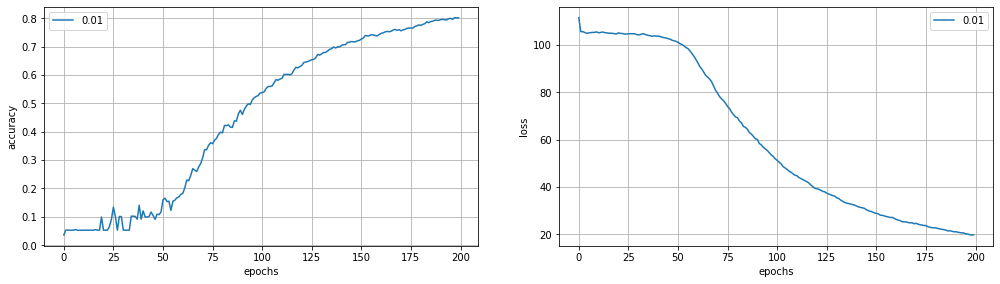

In [11]:
# passing dictionary but running with both users no partial
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_accuracy,label=str(args.lr))
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss,label=str(args.lr))
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()
filename = 'femnist'+args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
figures.savefig(filename)

In [12]:
import csv
filename = args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
with open(filename+'.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(train_accuracy) 
    write.writerow(train_loss)

In [13]:
import csv
train_acc_stored = []
with open('FedDR_10of30'+'.csv', 'r') as f:
  data = csv.reader(f)
  for row in data:
    train_acc_stored.append(row)
train_loss_stored = train_acc_stored.pop()
train_acc_stored_1 = [float(train_acc_stored[0][i]) for i in range(200)]
train_loss_stored_1 = [float(train_loss_stored[i]) for i in range(200)]

train_acc_stored = []
with open('FedPD_10of30'+'.csv', 'r') as f:
  data = csv.reader(f)
  for row in data:
    train_acc_stored.append(row)
train_loss_stored = train_acc_stored.pop()
train_acc_stored_2 = [float(train_acc_stored[0][i]) for i in range(200)]
train_loss_stored_2 = [float(train_loss_stored[i]) for i in range(200)]

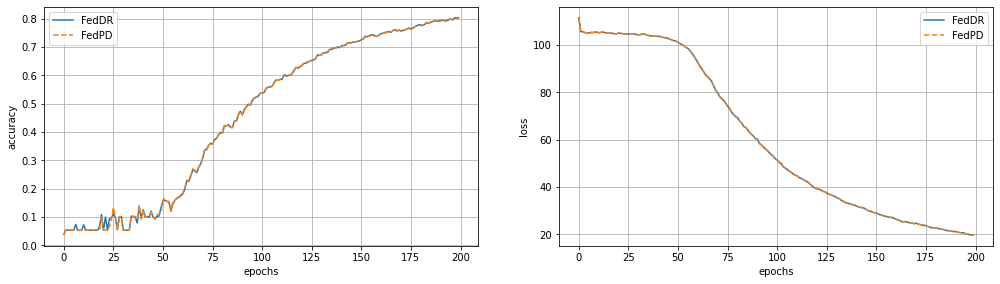

In [14]:
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_acc_stored_1, label='FedDR')
axes[0].plot(train_acc_stored_2,linestyle = 'dashed',label='FedPD')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss_stored_1, label='FedDR')
axes[1].plot(train_loss_stored_2,linestyle = 'dashed', label='FedPD')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()